In [140]:
import numpy as np
import pandas as pd
import os
import spacy
import en_core_web_sm
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS
import string
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer,HashingVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
!pip install vaderSentiment
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [141]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [142]:
# preprocessing the data file
#  read the data
df1 = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/drugsComTrain_raw.csv")
df2 = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/drugsComTest_raw.csv")
# combine two file
df = pd.concat([df1, df2])
df
# rename the cols
df.columns = ['ID','drug name','condition','review','rating','date','useful count']

In [143]:
print(df1.shape)
print(df2.shape)
print(df.shape)

(161297, 7)
(53766, 7)
(215063, 7)


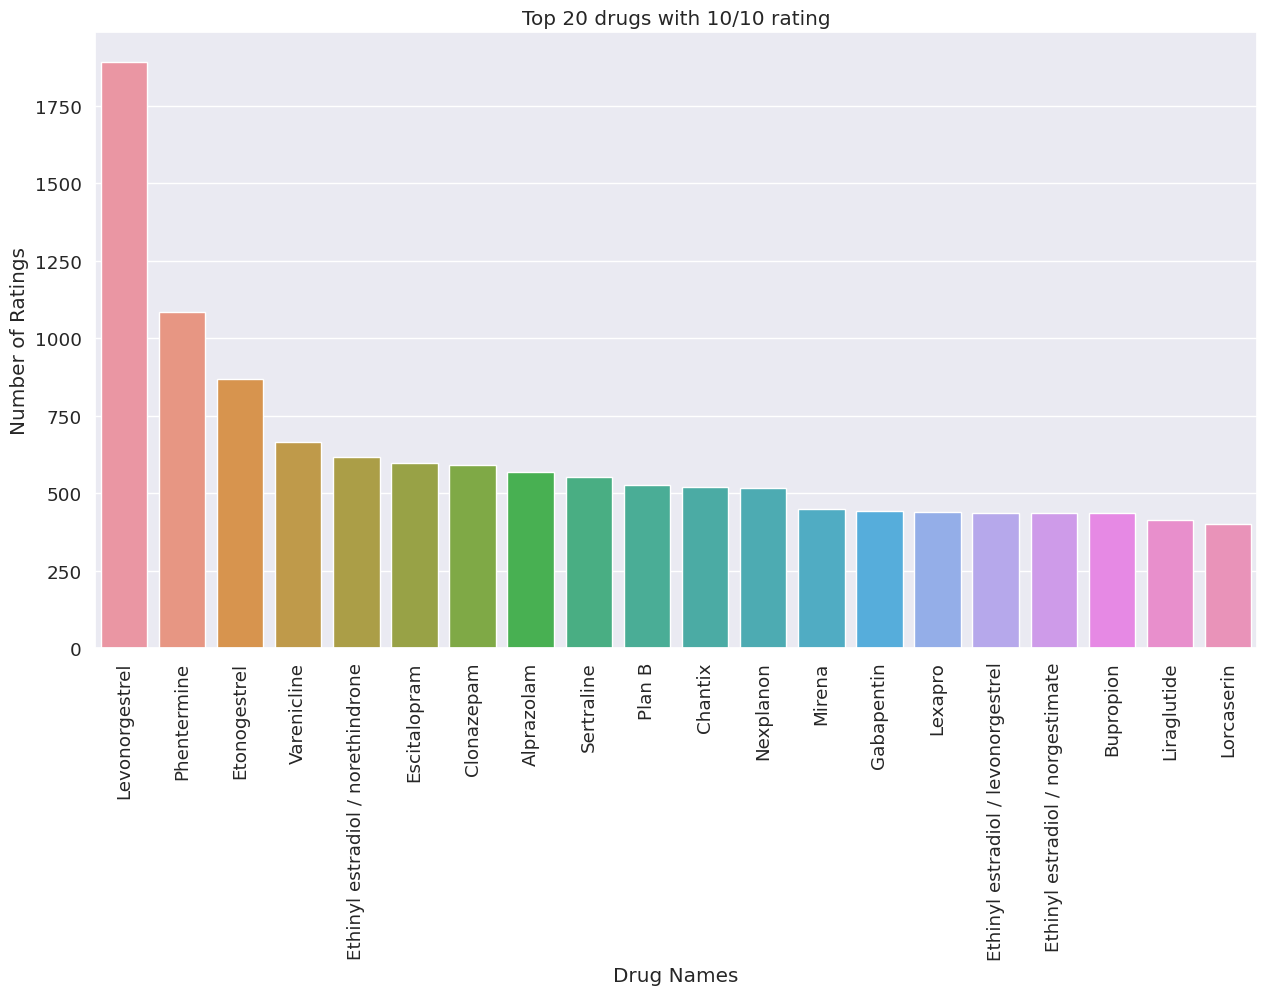

In [144]:
import seaborn as sns
#!pip install matplotlib
import matplotlib.pyplot as plt

# Setting the Parameter
sns.set(font_scale = 1.2, style = 'darkgrid')
plt.rcParams['figure.figsize'] = [15, 8]

rating = dict(df.loc[df.rating == 10, "drug name"].value_counts())
drugname = list(rating.keys())
drug_rating = list(rating.values())

sns_rating = sns.barplot(x = drugname[0:20], y = drug_rating[0:20])

sns_rating.set_title('Top 20 drugs with 10/10 rating')
sns_rating.set_ylabel("Number of Ratings")
sns_rating.set_xlabel("Drug Names")
plt.setp(sns_rating.get_xticklabels(), rotation=90);

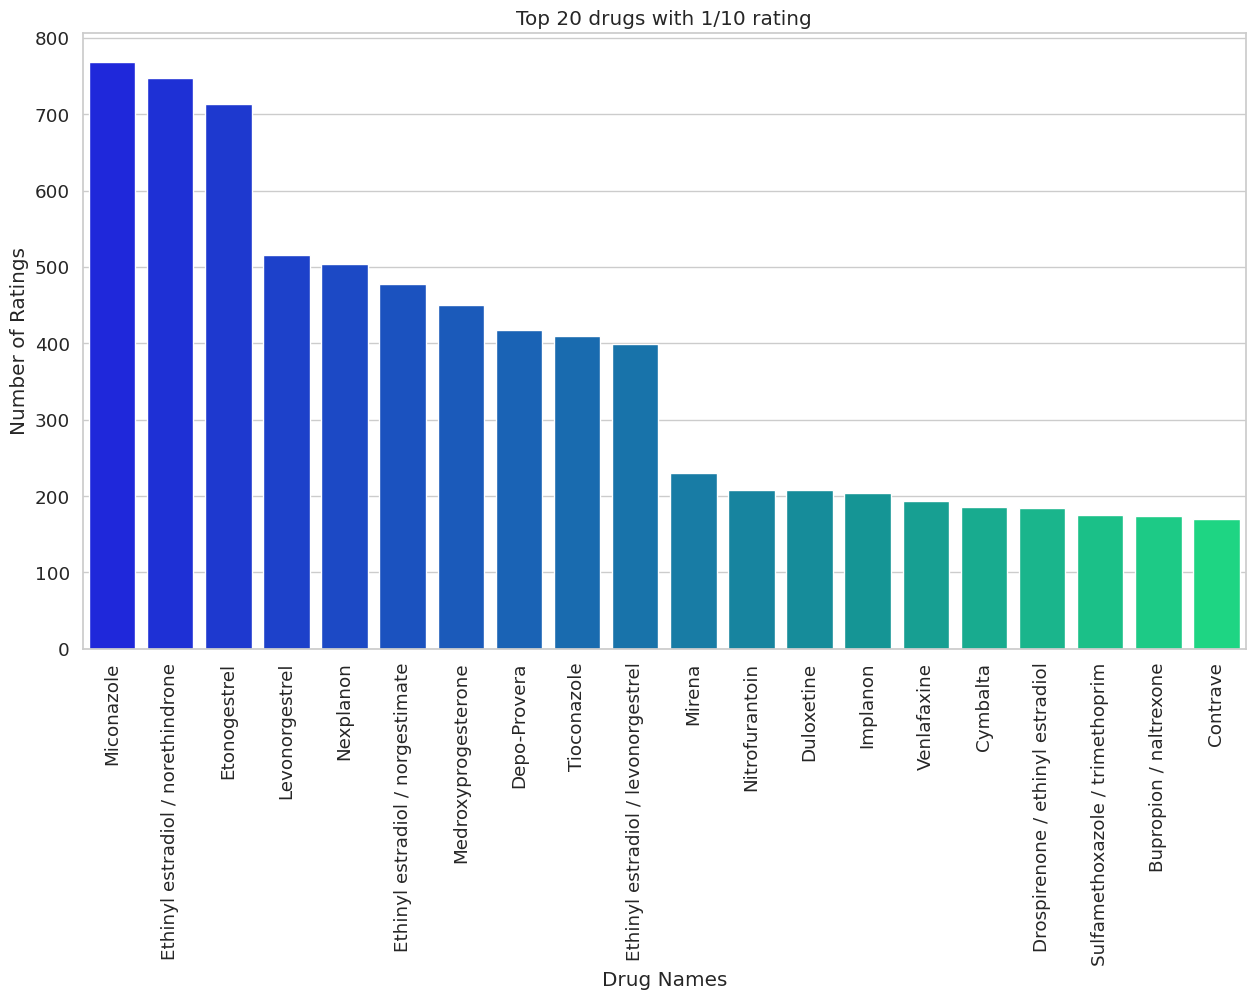

In [145]:
# Setting the Parameter
sns.set(font_scale = 1.2, style = 'whitegrid')
plt.rcParams['figure.figsize'] = [15, 8]

rating = dict(df.loc[df.rating == 1, "drug name"].value_counts())
drugname = list(rating.keys())
drug_rating = list(rating.values())

sns_rating = sns.barplot(x = drugname[0:20], y = drug_rating[0:20], palette = 'winter')

sns_rating.set_title('Top 20 drugs with 1/10 rating')
sns_rating.set_ylabel("Number of Ratings")
sns_rating.set_xlabel("Drug Names")
plt.setp(sns_rating.get_xticklabels(), rotation=90);

In [146]:
df

,ID,drug name,condition,review,rating,date,useful count
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37
...,...,...,...,...,...,...,...
53761,159999,Tamoxifen,"Breast Cancer, Prevention","""I have taken Tamoxifen for 5 years. Side effe...",10,13-Sep-14,43
53762,140714,Escitalopram,Anxiety,"""I&#039;ve been taking Lexapro (escitaploprgra...",9,8-Oct-16,11
53763,130945,Levonorgestrel,Birth Control,"""I&#039;m married, 34 years old and I have no ...",8,15-Nov-10,7
53764,47656,Tapentadol,Pain,"""I was prescribed Nucynta for severe neck/shou...",1,28-Nov-11,20


In [147]:
df.columns

Index(['ID', 'drug name', 'condition', 'review', 'rating', 'date',
       'useful count'],
      dtype='object')

<ipython-input-148-ca76ccecdffc>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns_2 = sns.distplot(df['rating'], ax = ax[1])


Text(0.5, 0, 'Rating')

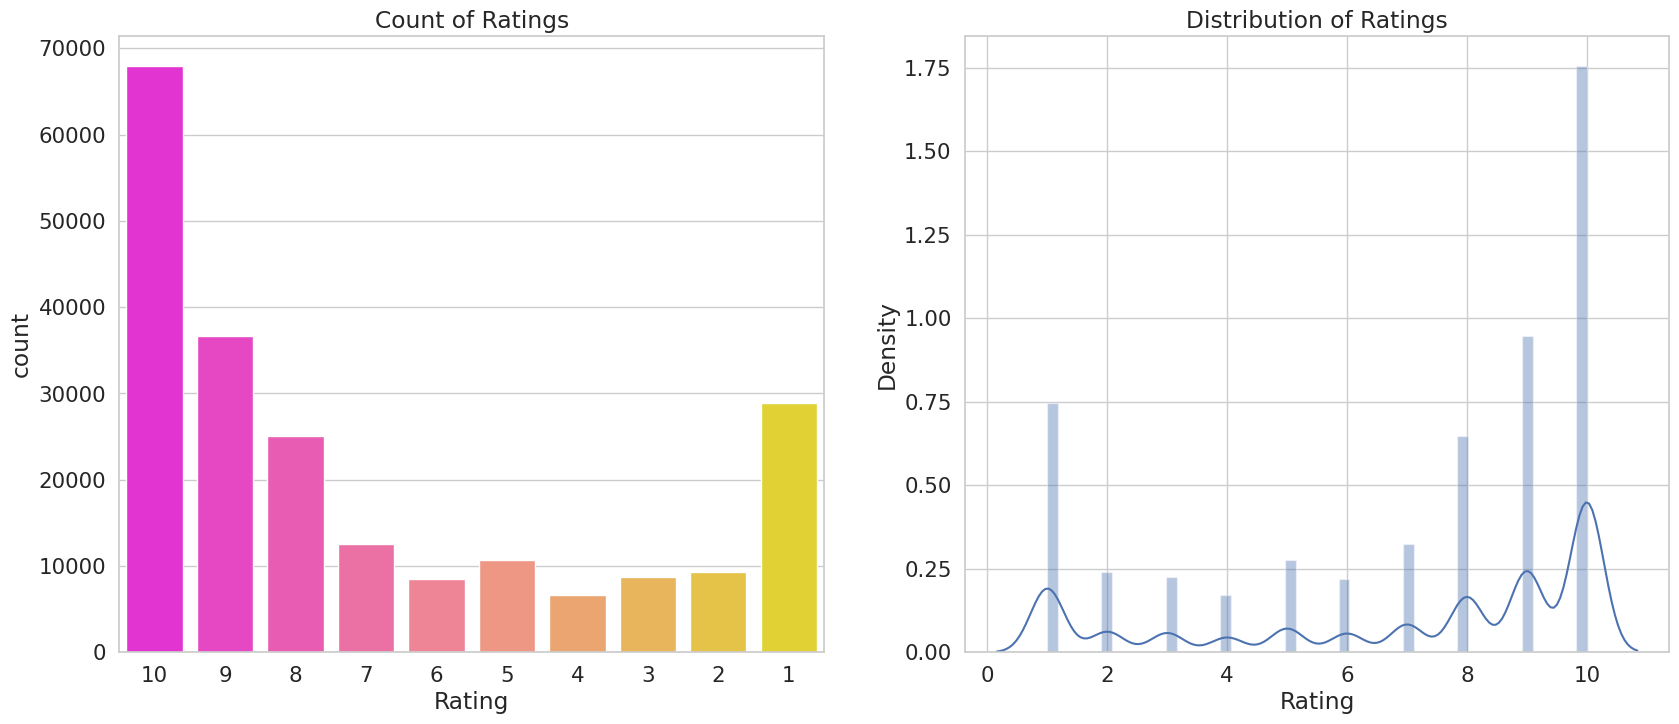

In [148]:
# A countplot of the ratings so we can see the distribution of the ratings
plt.rcParams['figure.figsize'] = [20,8]
sns.set(font_scale = 1.4, style = 'whitegrid')
fig, ax = plt.subplots(1, 2)
sns_1 = sns.countplot(x='rating', data=df, palette='spring', order=list(range(10, 0, -1)), ax=ax[0])
sns_2 = sns.distplot(df['rating'], ax = ax[1])
sns_1.set_title('Count of Ratings')
sns_1.set_xlabel("Rating")

sns_2.set_title('Distribution of Ratings')
sns_2.set_xlabel("Rating")

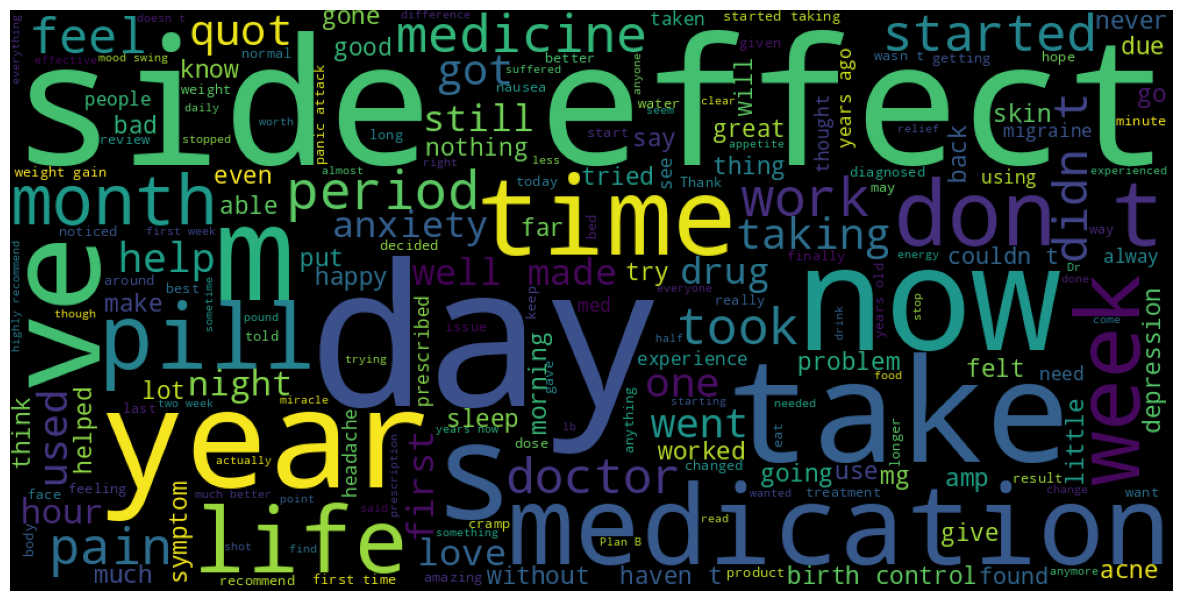

In [149]:
#!pip install wordcloud
from wordcloud import WordCloud# Word cloud of the reviews with rating equal to 10
df_rate_ten = df.loc[df.rating == 10, 'review']
k = (' '.join(df_rate_ten))

wordcloud = WordCloud(width = 1000, height = 500).generate(k)
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud)
plt.axis('off');

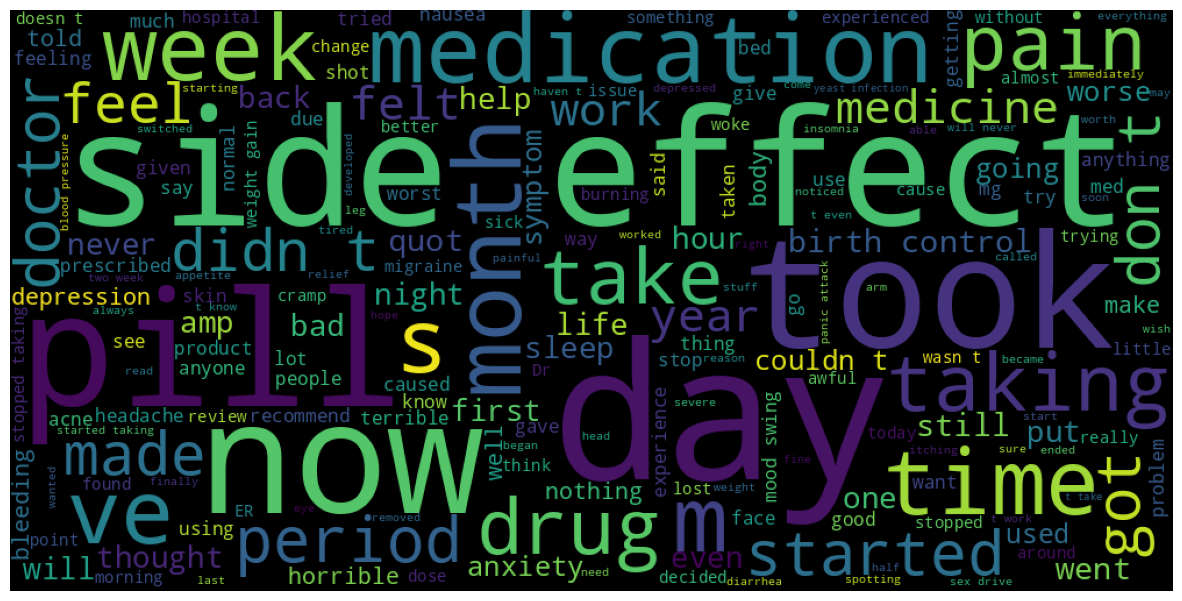

In [150]:
from wordcloud import WordCloud# Word cloud of the reviews with rating equal to 1
df_rate_ten = df.loc[df.rating == 1, 'review']
k = (' '.join(df_rate_ten))

wordcloud = WordCloud(width = 1000, height = 500).generate(k)
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud)
plt.axis('off');

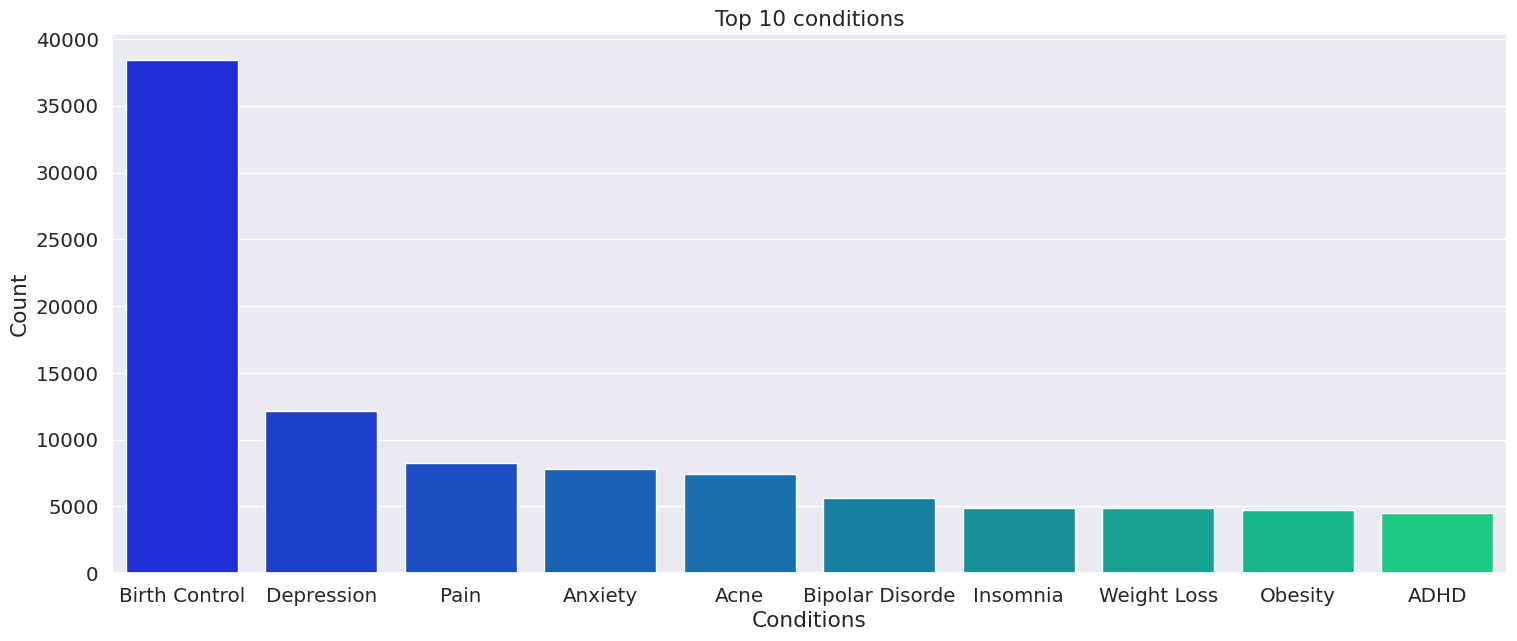

In [151]:
# This barplot show the top 10 conditions the people are suffering.
cond = dict(df['condition'].value_counts())
top_condition = list(cond.keys())[0:10]
values = list(cond.values())[0:10]
sns.set(style = 'darkgrid', font_scale = 1.3)
plt.rcParams['figure.figsize'] = [18, 7]

sns_ = sns.barplot(x = top_condition, y = values, palette = 'winter')
sns_.set_title("Top 10 conditions")
sns_.set_xlabel("Conditions")
sns_.set_ylabel("Count");

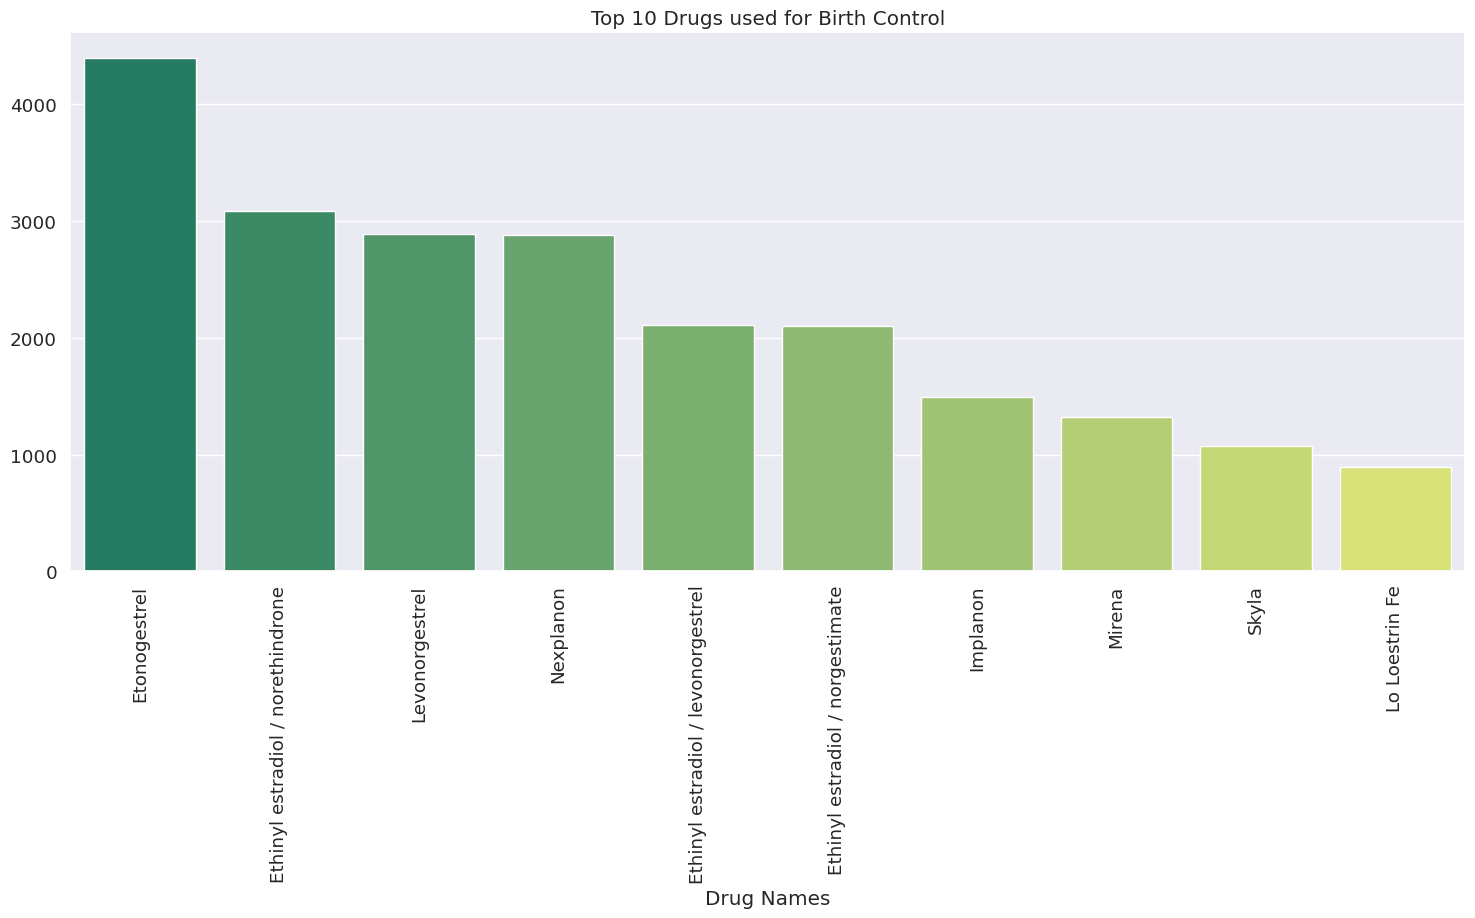

In [152]:
# Top 10 drugs which are used for the top condition, that is Birth Control
df_cond_birth = df[df['condition'] == 'Birth Control']['drug name'].value_counts()[0: 10]
sns.set(font_scale = 1.2, style = 'darkgrid')

sns_ = sns.barplot(x = df_cond_birth.index, y = df_cond_birth.values, palette = 'summer')
sns_.set_xlabel('Drug Names')
sns_.set_title("Top 10 Drugs used for Birth Control")
plt.setp(sns_.get_xticklabels(), rotation = 90);

In [153]:
df

,ID,drug name,condition,review,rating,date,useful count
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37
...,...,...,...,...,...,...,...
53761,159999,Tamoxifen,"Breast Cancer, Prevention","""I have taken Tamoxifen for 5 years. Side effe...",10,13-Sep-14,43
53762,140714,Escitalopram,Anxiety,"""I&#039;ve been taking Lexapro (escitaploprgra...",9,8-Oct-16,11
53763,130945,Levonorgestrel,Birth Control,"""I&#039;m married, 34 years old and I have no ...",8,15-Nov-10,7
53764,47656,Tapentadol,Pain,"""I was prescribed Nucynta for severe neck/shou...",1,28-Nov-11,20


In [154]:
df2 = df[df['useful count'] > 10]

In [155]:
df_condition = df2.groupby(['condition'])['drug name'].nunique().sort_values(ascending=False)
df_condition = pd.DataFrame(df_condition).reset_index()
df_condition.tail(20)

,condition,drug name
706,64</span> users found this comment helpful.,1
707,92</span> users found this comment helpful.,1
708,Gastritis/Duodenitis,1
709,Esophageal Variceal Hemorrhage Prophylaxis,1
710,98</span> users found this comment helpful.,1
711,Severe Mood Dysregulation,1
712,Short Stature,1
713,Short Stature for Age,1
714,Meningitis,1
715,"Skin Disinfection, Preoperative",1


In [156]:
df_condition_1 = df_condition[df_condition['drug name'] == 1].reset_index()

all_list = set(df.index)

# deleting them
condition_list = []
for i,j in enumerate(df['condition']):
    for c in list(df_condition_1['condition']):
        if j == c:
            condition_list.append(i)

new_idx = all_list.difference(set(condition_list))
df = df.iloc[list(new_idx)].reset_index()
del df['index']

In [157]:
df.shape

(160684, 7)

In [158]:
# removing the conditions with  in it.

all_list = set(df.index)
span_list = []
for i,j in enumerate(df['condition']):
    if "" in str(j):
        span_list.append(i)
new_idx = all_list.difference(set(span_list))
df = df.iloc[list(new_idx)].reset_index()
del df['index']

In [159]:
import re
from bs4 import BeautifulSoup
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [160]:
# removing some stopwords from the list of stopwords as they are important for drug recommendation

stops = set(stopwords.words('english'))

not_stop = ["aren't","couldn't","didn't","doesn't","don't","hadn't","hasn't","haven't","isn't","mightn't",
            "mustn't","needn't","no","nor","not","shan't","shouldn't","wasn't","weren't","wouldn't"]
for i in not_stop:
    stops.remove(i)

In [163]:
criteria = [df['vaderReviewScore'].between(-0.997, -0.799), df['vaderReviewScore'].between(-0.798, -0.601), df['vaderReviewScore'].between(-0.600, 0.403), df['vaderReviewScore'].between(-0.402, -0.205), df['vaderReviewScore'].between(-0.204, -0.007), df['vaderReviewScore'].between(-0.006,0.191), df['vaderReviewScore'].between(0.192, 0.389), df['vaderReviewScore'].between(0.390, 0.587), df['vaderReviewScore'].between(0.588, 0.785), df['vaderReviewScore'].between(0.786, 1)]
values = [1, 2, 3,4,5,6,7,8,9,10]

df['normalVaderScore'] = np.select(criteria, values, 0)
df

KeyError: ignored

In [ ]:
df

In [ ]:
bow_vector = CountVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,2))
#  tf-idf vector
tfidf_vector = TfidfVectorizer(tokenizer = spacy_tokenizer)

In [ ]:
criteria = [df['vaderReviewScore'].between(-0.997, -0.799), df['vaderReviewScore'].between(-0.798, -0.601), df['vaderReviewScore'].between(-0.600, 0.403), df['vaderReviewScore'].between(-0.402, -0.205), df['vaderReviewScore'].between(-0.204, -0.007), df['vaderReviewScore'].between(-0.006,0.191), df['vaderReviewScore'].between(0.192, 0.389), df['vaderReviewScore'].between(0.390, 0.587), df['vaderReviewScore'].between(0.588, 0.785), df['vaderReviewScore'].between(0.786, 1)]
values = [1, 2, 3,4,5,6,7,8,9,10]

df['normalVaderScore'] = np.select(criteria, values, 0)

In [ ]:
df

In [ ]:
df['vaderReviewScore'].min()

In [ ]:
#Normalizing "vaderReviewScore"
criteria = [df['vaderReviewScore'].between(-0.997, -0.799), df['vaderReviewScore'].between(-0.798, -0.601), df['vaderReviewScore'].between(-0.600, 0.403), df['vaderReviewScore'].between(-0.402, -0.205), df['vaderReviewScore'].between(-0.204, -0.007), df['vaderReviewScore'].between(-0.006,0.191), df['vaderReviewScore'].between(0.192, 0.389), df['vaderReviewScore'].between(0.390, 0.587), df['vaderReviewScore'].between(0.588, 0.785), df['vaderReviewScore'].between(0.786, 1)]
values = [1, 2, 3,4,5,6,7,8,9,10]

df['normalVaderScore'] = np.select(criteria, values, 0)

In [ ]:
df

In [ ]:
#Final Normalized Score combining Rating and normalVaderScore
df['meanNormalizedScore'] = (df['rating'] + df['normalVaderScore'])/2
df.head()

In [ ]:
#Sorting Data based on Condition and then by drug
grouped = df.groupby(['condition','drug name']).agg({'meanNormalizedScore' : ['mean']})
grouped.to_csv('Grouped_Drug_Recommendation_Normalized')
grouped.head(10)

In [ ]:
#Verification using Machine Learning Models
from sklearn.model_selection import train_test_split

x_train, x_test = train_test_split(df, test_size = 0.25, random_state = 0)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

cv = CountVectorizer(max_features = 20000, ngram_range = (4, 4))
pipeline = Pipeline([('vect',cv)])

x_train_features = pipeline.fit_transform(x_train['review_clean'])
x_test_features = pipeline.fit_transform(x_test['review_clean'])

print("x_train_features :", x_train_features.shape)
print("x_test_features :", x_test_features.shape)
# let's make a new column review sentiment

df.loc[(df['rating'] >= 5), 'Review_Sentiment'] = 1
df.loc[(df['rating'] < 5), 'Review_Sentiment'] = 0

df['Review_Sentiment'].value_counts()

In [ ]:
import six
import sys
sys.modules['sklearn.externals.six'] = six
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from mlxtend.classifier import StackingClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import precision_score, confusion_matrix, recall_score
from sklearn.metrics import classification_report
# making our dependent variable



features = df['review_clean'] # the features we want to analyze
labels = df['Review_Sentiment'] # the labels, we want to test against
X_train, X_test, y_train, y_test= train_test_split(features, labels, test_size=0.2, random_state=0)

clf2 = LogisticRegression(random_state=0,solver='lbfgs',max_iter=2000,multi_class='auto')
#clf3 = SVC(kernel="linear", C=5)
clf7 = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42, max_

In [ ]:
#LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

# Create a CountVectorizer for text feature extraction
vectorizer = CountVectorizer()

# Fit the vectorizer on the training data and transform the data
X_train_vec = vectorizer.fit_transform(X_train)

# Transform the test data using the same vectorizer
X_test_vec = vectorizer.transform(X_test)

# Create a Logistic Regression classifier
logreg = LogisticRegression()

# Fit the classifier on the vectorized training data and corresponding labels
logreg.fit(X_train_vec, y_train)

# Make predictions on the test data
y_pred_logreg = logreg.predict(X_test_vec)

# Calculate the accuracy score
logreg_accuracy = accuracy_score(y_test, y_pred_logreg)
print("Log Reg: ", logreg_accuracy)

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Obtain the predicted probabilities for the positive class
y_score = logreg.predict_proba(X_test_vec)[:, 1]

# Calculate the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_score)

# Calculate the AUC score
roc_auc = auc(fpr, tpr)

In [ ]:
#Classification Report
target_names = ["class 1", "class 2"]
print(classification_report(y_test, y_pred_logreg,target_names=target_names))

In [ ]:
#Confusion Matrix
cm2 = confusion_matrix(y_pred=y_pred_logreg, y_true=y_test)
cm2

In [ ]:
print('AUC: {}'.format(auc(fpr, tpr)))

In [ ]:
#SGD

# Fit the vectorizer on the training data and transform the data
X_train_vec = vectorizer.fit_transform(X_train)

# Transform the test data using the same vectorizer
X_test_vec = vectorizer.transform(X_test)

# Create a SGD classifier
SGDC = SGDClassifier(loss='log')

# Fit the classifier on the vectorized training data and corresponding labels
SGDC.fit(X_train_vec, y_train)

# Make predictions on the test data
y_pred_SGD = SGDC.predict(X_test_vec)

# Calculate the accuracy score
SGDC_accuracy = accuracy_score(y_test, y_pred_SGD)
print("SGD Classification: ", SGDC_accuracy)

In [ ]:
# Obtain the predicted probabilities for the positive class
y_score_SGD = SGDC.predict_proba(X_test_vec)[:, 1]

# Calculate the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_score)

# Calculate the AUC score
roc_auc = auc(fpr, tpr)

In [ ]:
#Classification Report
target_names = ["class 1", "class 2"]
print(classification_report(y_test, y_pred_SGD,target_names=target_names))

In [ ]:
#Confusion Matrix
cm3 = confusion_matrix(y_pred=y_pred_SGD, y_true=y_test)
cm3

In [ ]:
#MultinomialNB

# Fit the vectorizer on the training data and transform the data
X_train_vec = vectorizer.fit_transform(X_train)

# Transform the test data using the same vectorizer
X_test_vec = vectorizer.transform(X_test)

# Create a Multinomial Naive Bayes classifier
MultiNB = MultinomialNB()

# Fit the classifier on the vectorized training data and corresponding labels
MultiNB.fit(X_train_vec, y_train)

# Make predictions on the test data
y_pred_MultiNB = MultiNB.predict(X_test_vec)

# Calculate the accuracy score
MultiNB_accuracy = accuracy_score(y_test, y_pred_MultiNB)
print("MultinomialNB: ", MultiNB_accuracy)

In [ ]:
# Obtain the predicted probabilities for the positive class
y_score_MultiNB = MultiNB.predict_proba(X_test_vec)[:, 1]

# Calculate the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_score)

# Calculate the AUC score
roc_auc = auc(fpr, tpr)

In [ ]:
#Classification Report
target_names = ["class 1", "class 2"]
print(classification_report(y_test, y_pred_MultiNB,target_names=target_names))

In [ ]:
#Confusion Matrix
cm4 = confusion_matrix(y_pred=y_pred_MultiNB, y_true=y_test)
cm4